<a href="https://colab.research.google.com/github/di-wu-dw/teamA-grebes-NMA2020/blob/master/20200717_DW_Stringer_Spontaneous_Running.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM'])



dat has fields:
* dat['sresp']: neurons by timebins, a.k.a. the neural response data (14752 by 8118). Timebin = 1.2 sec.
* dat['run']: timebins by 1, a.k.a. the running speed of the animal in a.u.
* dat['stat']: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.
* dat['stat'][k]['med']: 1 by 2, the position of each neuron k in tissue, in pixels, at a resolution of ~2um/pix. 
* dat['pupilArea']: timebins by 1, see FaceMap for details on the pupil tracker
* dat['pupilCOM']: timebins by 2, correspond to X and Y position. See FaceMap for details on the pupil tracker.
* dat['beh_svd_time']: timebins by 1,000. Timecourses of behavioral SVDs extracted from face movies. See FaceMap for details. 
* dat['beh_svd_mask']: 240 by 320 by 1,000. Spatial masks of behavioral SVDs. Roughly normalized to each other. 
* dat['beh_svd_mask'] @ dat['beh_svd_time'][T, :]:  reconstruction of the face movie (its motion energy) for frame T

In [4]:
print(dat['sresp'].shape)
print(len(dat['stat']))
print((dat['stat'][19].dtype))
print(dat['stat'][19]['med'])

(11983, 7018)
11983
[('ipix', 'O'), ('ypix', 'O'), ('xpix', 'O'), ('lam', 'O'), ('lambda', 'O'), ('npix', 'O'), ('med', 'O'), ('neuropilCoefficient', 'O'), ('baseline', 'O'), ('footprint', 'O'), ('mrs', 'O'), ('mrs0', 'O'), ('cmpct', 'O'), ('aspect_ratio', 'O'), ('ellipse', 'O'), ('mimgProj', 'O'), ('mimgProjAbs', 'O'), ('isoverlap', 'O'), ('radius', 'O'), ('ipix_neuropil', 'O'), ('dFstat', 'O'), ('skew', 'O'), ('std', 'O'), ('maxMinusMed', 'O'), ('top5pcMinusMed', 'O'), ('blockstarts', 'O'), ('iplane', 'O'), ('iscell', 'O'), ('noiseLevel', 'O')]
[array([[191.5,  23. ]])]


In [5]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [6]:
#@title global variables
training_len = 5000 #cut-off index for training vs testing

N = len(dat['stat']) #total number of Neurons

# Ca2+ Signal

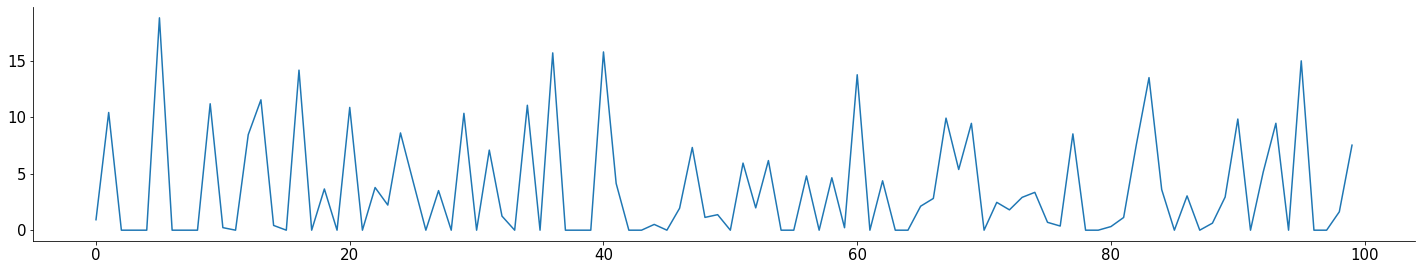

In [7]:
neuron_idx = 5
stop_len = 100
plt.plot(dat['sresp'][neuron_idx,:stop_len])

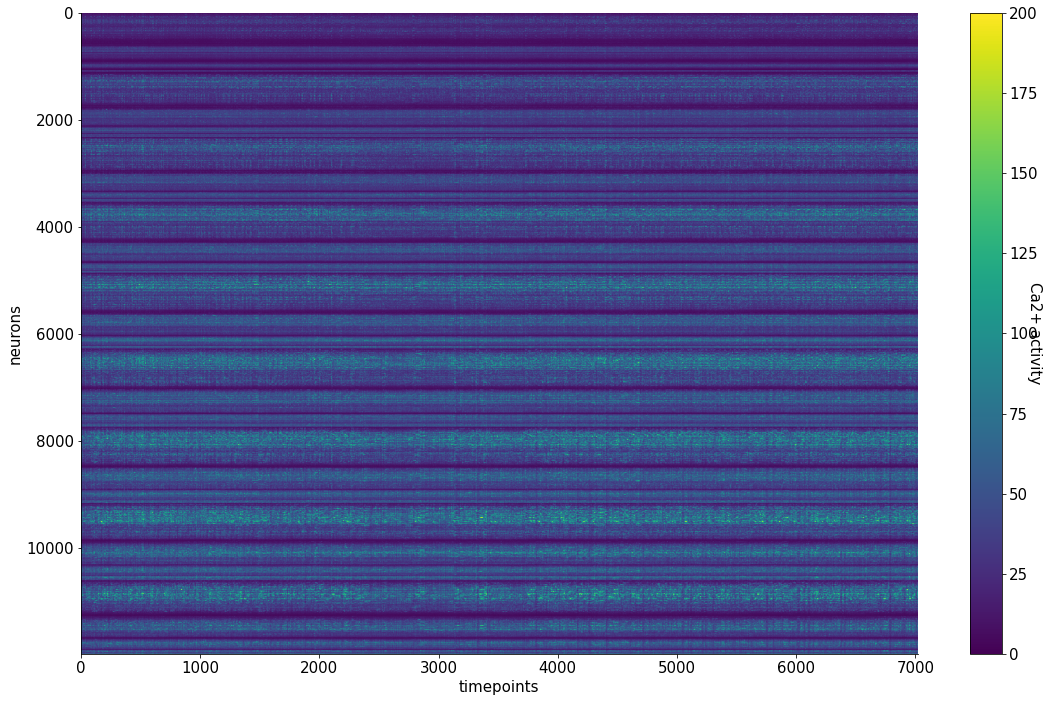

In [8]:
#@title plotting all the data
N = 11983 # number of neurons for plotting
stop_len = 7018 #cut-off index for plotting time-trace
saturation = 200 #saturate pixel with activity level above this

plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.imshow(dat['sresp'][:N,:stop_len], vmax = saturation, aspect = 'auto',cmap = 'viridis')
ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
cbar.set_label('Ca2+ activity', rotation=270)

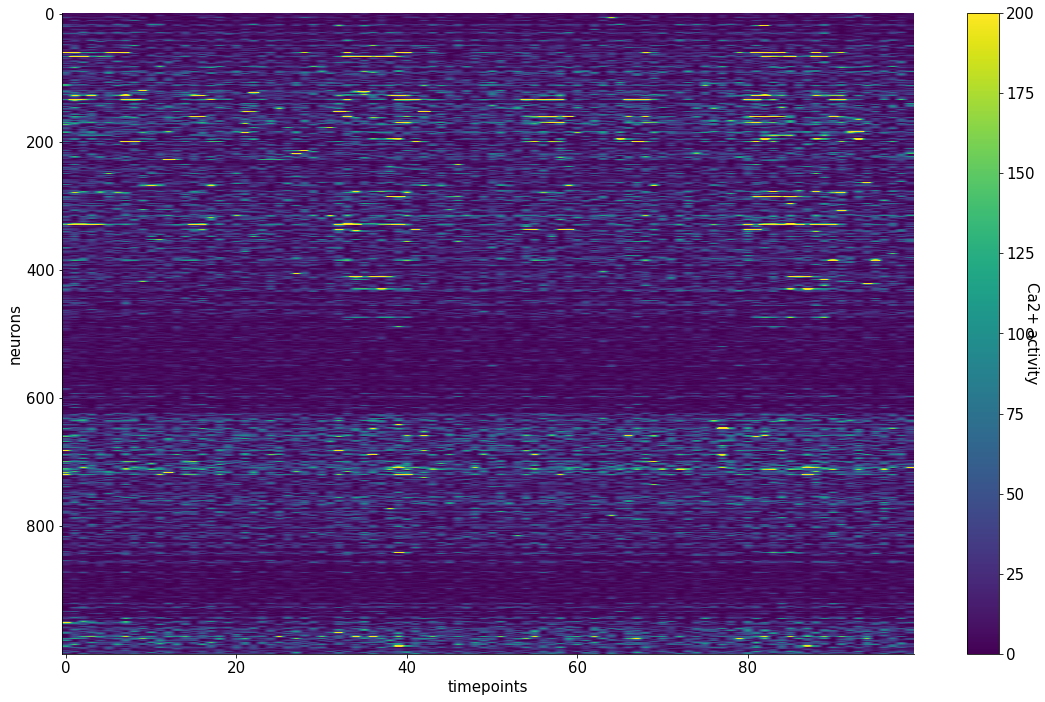

In [9]:
#@title plotting a sub-set
N = 1000 # number of neurons for plotting
stop_len = 100 #cut-off index for plotting time-trace
saturation = 200 #saturate pixel with activity level above this

plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.imshow(dat['sresp'][:N,:stop_len], vmax = saturation, aspect = 'auto',cmap = 'viridis')
ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
cbar.set_label('Ca2+ activity', rotation=270)

# Running Speed

[False, True, True, True, True, True, True, True, True, True, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, False, False, False, False, False, False, True, True, True, True, True, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, False, False]


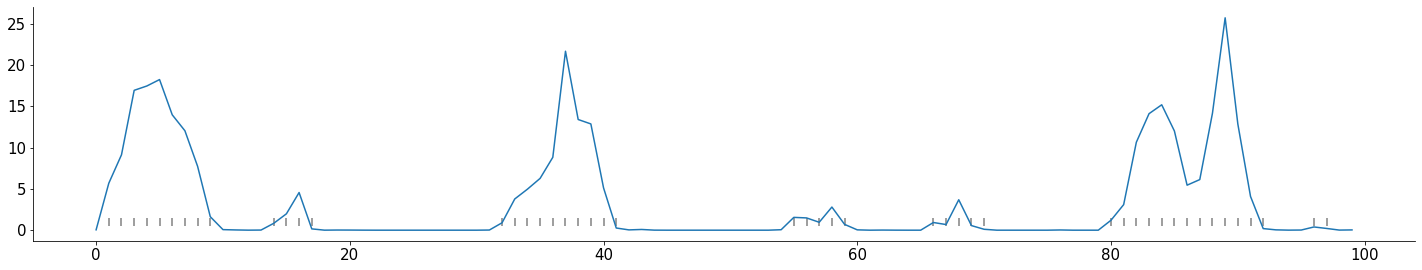

In [10]:
#@title Convert running speed to binary variable: run and not run
run_thres = 0.1 #cut-off threhold for running speed to be considered running [a.u.]

plt.plot(dat['run'][:stop_len])

t = np.arange(stop_len)

run_idx = [x[0] for x in dat['run'] > run_thres]
print(run_idx[:stop_len])

plt_run_idx = run_idx[:stop_len]
plt.eventplot(t[plt_run_idx], color="0.5")

# Logistic Regression of Neural Data onto Running State

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [12]:
X = dat['sresp'][:,:training_len]
X = X.T

run_idx = [x[0] for x in dat['run'] > run_thres]
y = np.array(run_idx[:training_len])

## Logistic Regression with no regularization

In [13]:
# First define the model
log_reg = LogisticRegression(penalty="none")

#Then fit it to data
log_reg.fit(X, y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation

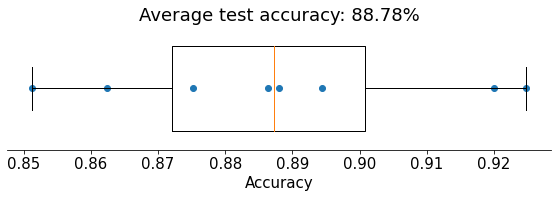

In [15]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

## Logistic Regression with L1 regularization

None converged, for C = [1, 10, 100], with the following warning message:

```
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)
```



In [16]:
# log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=100)
# log_reg_l1.fit(X, y)

In [17]:
# log_reg_l1 = LogisticRegression(penalty="l1", C=10, solver="saga", max_iter=100)
# log_reg_l1.fit(X, y)

In [18]:
# log_reg_l1 = LogisticRegression(penalty="l1", C=100, solver="saga", max_iter=100)
# log_reg_l1.fit(X, y)

# PCA to determine intrinsic dimensionality

In [19]:
from sklearn.decomposition import PCA
pca_model = PCA() # Initializes PCA
pca_model.fit(X) # Performs PCA 

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:
pca_model.components_
pca_model.explained_variance_

array([ 3.9721813e-04, -4.3855507e-05, -4.8327413e-05, ...,
       -1.0718402e-03, -2.7558412e-03,  1.3803536e-05], dtype=float32)

In [25]:
def plot_variance_explained(variance_explained):
  """
  Plots eigenvalues.

  Args:
    variance_explained (numpy array of floats) : Vector of variance explained
                                                 for each PC

  Returns:
    Nothing.

  """

  plt.figure()
  plt.plot(np.arange(1, len(variance_explained) + 1), variance_explained,
           '--k')
  plt.xlabel('Number of components')
  plt.ylabel('Variance explained')
  plt.show()

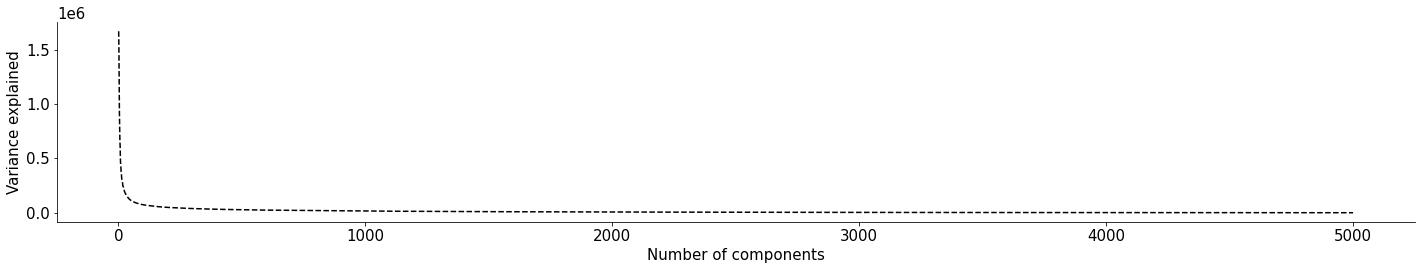

In [26]:
plot_variance_explained(pca_model.explained_variance_)

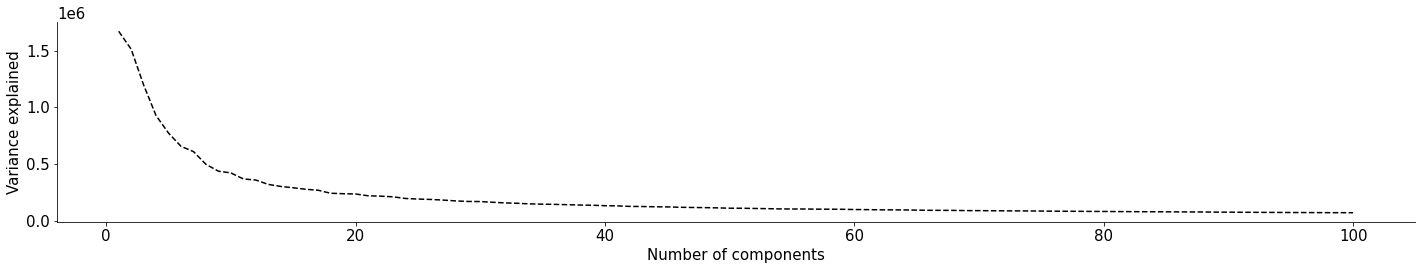

In [29]:
plot_variance_explained(pca_model.explained_variance_[:100])

## Transform input using first 100 PCs

In [32]:
X_pc = PCA(n_components=100).fit_transform(X)

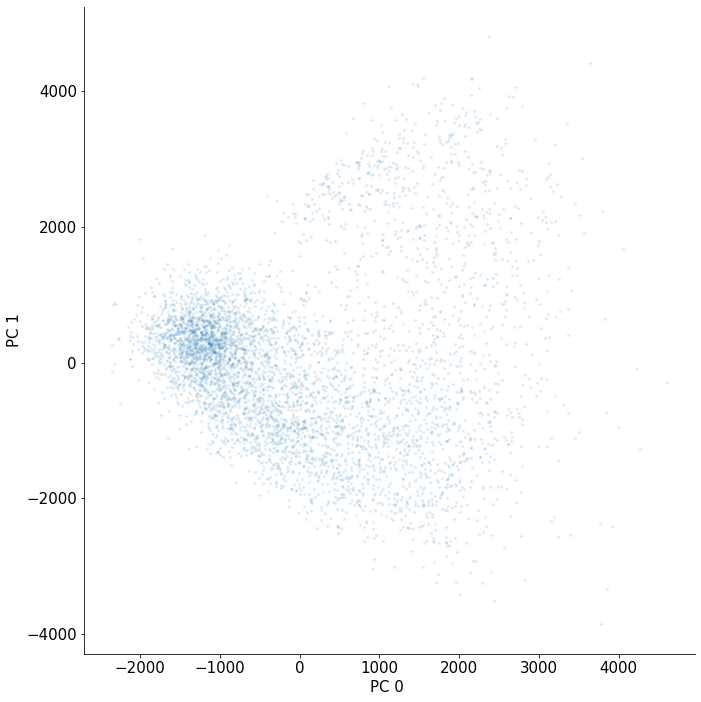

In [39]:
plt.figure(figsize=(10,10))
ax = plt.subplot(1,1,1)
plt.scatter(X_pc[:,0], X_pc[:,1], s = 4, alpha = .1)
ax.set(xlabel = 'PC 0 ', ylabel = 'PC 1');

# PCs as input features to logistic regression

In [30]:
pca_model.components_[0,:]

array([ 2.5205733e-04, -2.2620364e-04, -1.2642547e-04, ...,
       -8.1303110e-04,  5.5209384e-04, -6.8032001e-05], dtype=float32)

In [40]:
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=100)
log_reg_l1.fit(X_pc, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
accuracies = cross_val_score(log_reg_l1, X_pc, y, cv=8) # k=8 crossvalidation

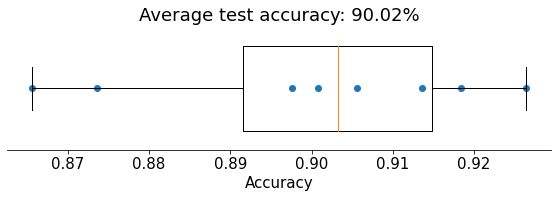

In [42]:
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)

In [47]:
def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="PC")
  f.tight_layout()

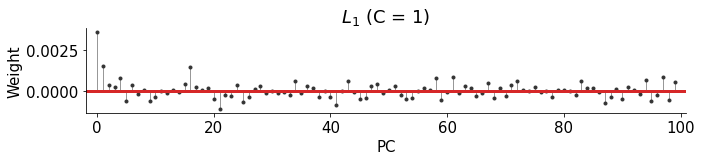

In [48]:
plot_weights({"$L_1$ (C = 1)": log_reg_l1})

## Model Selection: Hyperparameter Tuning

In [51]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.
  Returns:
    accuracies (1D array): CV accuracy with each value of C.
  """
  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)

    # Get the accuracy for each test split
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies


def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )

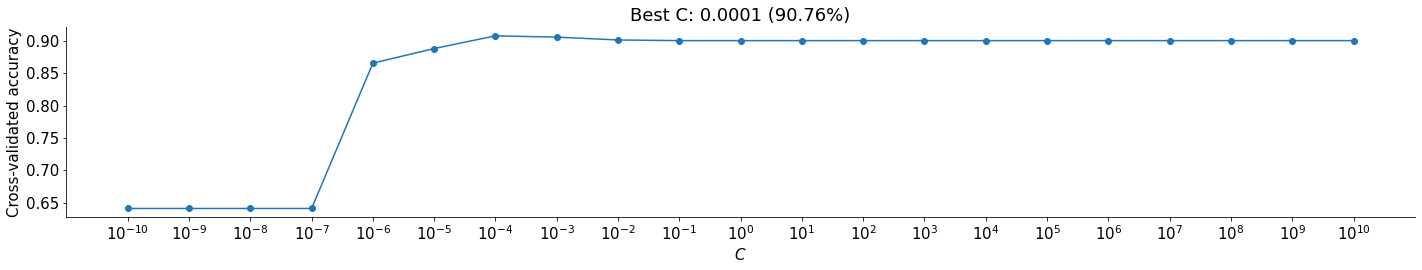

In [55]:
# Use log-spaced values for C
C_values = np.logspace(-10, 10, 21)

accuracies = model_selection(X_pc, y, C_values)

plot_model_selection(C_values, accuracies)